# Active Learning on Covid lung scans with VGG16

We will use tensorflow to import the vgg 16 model.  
The dataset can be found here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

## Loading dataset and creating training and test set

In [1]:
import os

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Import classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

#from keras.applications.vgg16 import VGG16

In [2]:
# Three main subfolders: COVID, Normal, Viral Pneumonia
subfolders = ["COVID/", "Normal/", "Viral Pneumonia/"]
path = "ActiveLearning_ImageClassification/COVID-19_Radiography_Dataset/"
data = {}
size = 0

# Every subfolder has images and their masks
for subfolder in subfolders:
    data[subfolder + "images"] = [path + subfolder + "images/" + image for image in os.listdir(path + subfolder + "images")]
    data[subfolder + "masks"] = [path + subfolder + "masks/" + image for image in os.listdir(path + subfolder + "masks")]
    print(f"Number of images in {subfolder}: {len(data[subfolder + 'images'])}")
    print(f"Number of masks in {subfolder}: {len(data[subfolder + 'masks'])}")
    size += len(data[subfolder + 'images'])
                
print(f"Total size: {str(size)}")

Number of images in COVID/: 3616
Number of masks in COVID/: 3616
Number of images in Normal/: 10192
Number of masks in Normal/: 10192
Number of images in Viral Pneumonia/: 1345
Number of masks in Viral Pneumonia/: 1345
Total size: 15153


(299, 299)
(299, 299)
(299, 299)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(299, 299)
(299, 299)
(299, 299)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(299, 299)
(299, 299)
(299, 299)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


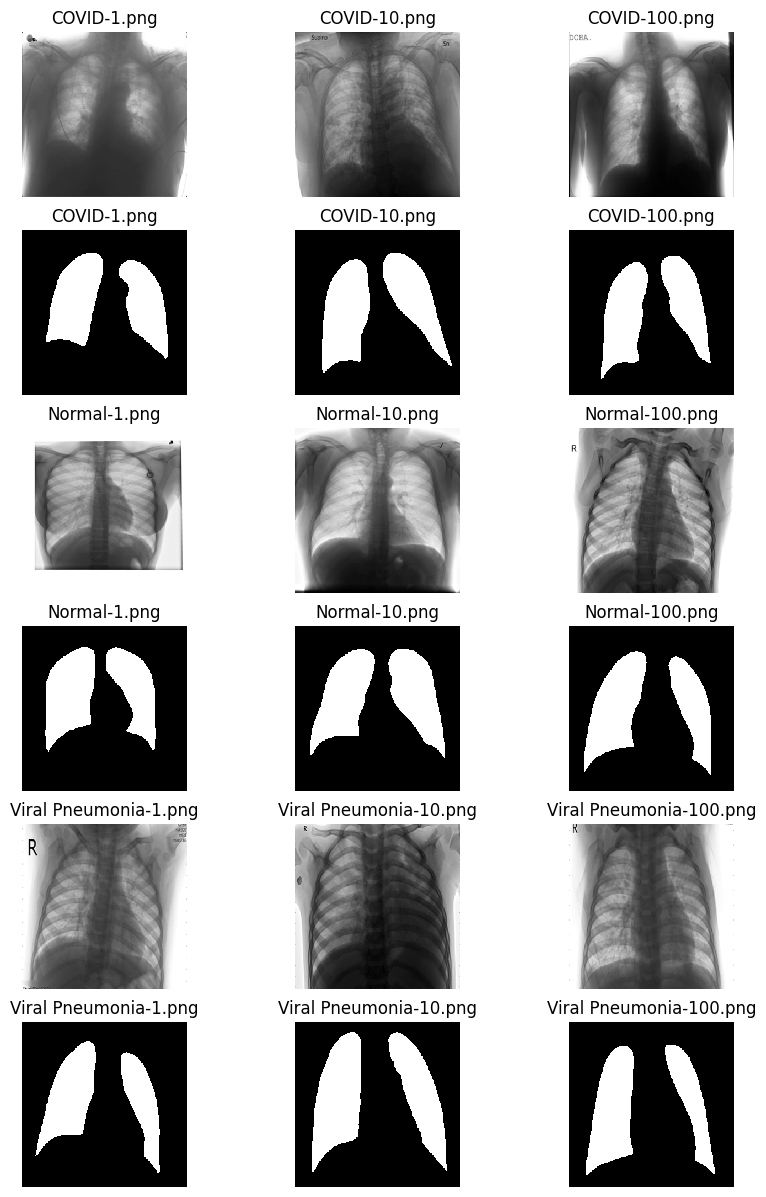

In [7]:
# Load image paths and show 3 examples of the scans, both image and mask

# Tunable parameters
num_images = 3 # number of images to show
versions = ["images", "masks"] # show both image and mask, default: ["images", "masks"]

examples_path = []
examples_images = []

for subfolder in subfolders:
    for version in versions:
        examples_path += data[subfolder + version][0:num_images]
        for image in examples_path[-num_images:]:
            examples_images.append(plt.imread(image))
            print(plt.imread(image).shape)

_, axes = plt.subplots(nrows=len(subfolders) * len(versions), ncols=num_images, figsize=(10, 15))
for ax, image, label in zip(axes.flatten(), examples_images, examples_path):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%s" % label.split("/")[-1])

In [ ]:
# Create the training data, might take a while
X = np.zeros((size, 299, 299), dtype=np.float32)

index = 0
test = 0
for subfolder in subfolders:
    for image in data[subfolder + "images"]:
        loaded = plt.imread(image)
        
        # Some images are not 8 bit, so we convert them
        if (len(loaded.shape) != 2):
            from PIL import Image, Palette
            img=Image.open(image)
            new_img=img.convert("P", palette=Palette.ADAPTIVE, colors=8)
            new_img.save(image)
            loaded = plt.imread(image)
        else:
            X[index] = loaded
        index += 1

print(len(X))
y = np.concatenate([np.array([subfolder[:-1]] * len(data[subfolder + "images"])) for subfolder in subfolders])
print(len(y))

In [ ]:
# Split the dataset in training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

## Start Training model

In [1]:
from keras.applications.vgg16 import VGG16
model = VGG16()

2022-11-20 14:56:41.192489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 14:56:41.337975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 14:56:41.337999: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 14:56:42.162839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

553467096/553467096 [==============================] - 67s 0us/step


2022-11-20 14:57:52.862420: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
